In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score  #交叉验证评分
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error #均方根误差
from sklearn.metrics import roc_curve, auc, recall_score, precision_score
import warnings
warnings.filterwarnings("ignore")
# 导入数据，路径中要么用\\或/或者在路径前加r
dataset = pd.read_csv('../data/train_chuli.csv')

In [26]:
# 输出数据预览
print(dataset.head())

   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  \
0            1         0       3    1  22.0      1      0   7.2500   
1            2         1       1    0  38.0      1      0  71.2833   
2            3         1       3    0  26.0      0      0   7.9250   
3            4         1       1    0  35.0      1      0  53.1000   
4            5         0       3    1  35.0      0      0   8.0500   

   family_size  Embarked_C  Embarked_Q  Embarked_S  
0            2           0           0           1  
1            2           1           0           0  
2            1           0           0           1  
3            2           0           0           1  
4            1           0           0           1  


In [27]:
from sklearn.model_selection import train_test_split #划分数据集
# 准备训练数据
x = dataset.drop(['Survived'], axis = 1)
y = dataset['Survived']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0) 
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(623, 11) (268, 11) (623,) (268,)


In [28]:
#数据标准化
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler = StandardScaler()  
scaler.fit(x_train)
x_train = scaler.transform(x_train)  
x_test = scaler.transform(x_test)

In [29]:
from matplotlib.cm import rainbow 
from sklearn.neighbors import KNeighborsClassifier
#
rf_scores = []

rf_classifier =KNeighborsClassifier(n_neighbors=8)
rf_classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=8)

KNN参数解读
- n_neighbors,	选择n个邻居,	整型，默认为5
- radius,	半径,	选择距离小于等于radius的邻居值
- algorithm,	计算n近邻的算法	{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}，auto将自动确定适合的方法
- leaf_size,	计算树算法的叶子节点数目,	整型，默认为30，传递给ball_tree和kd_tree的参数
- metric,	距离度量方法,	-scikit-learn库: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’,‘manhattan’] -scipy.spatial.distance库: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’]
- p	,控制Minkowski度量方法的值,	整型，默认为2
- n_jobs,	对近邻计算的并行工作数,	除非在joblib.parallel_backend中，None表示1，-1表示使用所有的处理器

In [30]:
#评价指标
import numpy as np

# 计算混淆矩阵
def compute_confusion_matrix(precited,expected):
    part = precited ^ expected             # 对结果进行分类，亦或使得判断正确的为0,判断错误的为1
    pcount = np.bincount(part)             # 分类结果统计，pcount[0]为0的个数，pcount[1]为1的个数
    tp_list = list(precited & expected)    # 将TP的计算结果转换为list
    fp_list = list(precited & ~expected)   # 将FP的计算结果转换为list
    tp = tp_list.count(1)                  # 统计TP的个数
    fp = fp_list.count(1)                  # 统计FP的个数
    tn = pcount[0] - tp                    # 统计TN的个数
    fn = pcount[1] - fp                    # 统计FN的个数
    return tp, fp, tn, fn

# 计算常用指标
def compute_indexes(tp, fp, tn, fn):
    accuracy = (tp+tn) / (tp+tn+fp+fn)     # 准确率
    precision = tp / (tp+fp)               # 精确率
    recall = tp / (tp+fn)                  # 召回率
    F1 = (2*precision*recall) / (precision+recall)    # F1
    return accuracy, precision, recall, F1


In [35]:
rfc_score = rf_classifier.score(x_test, y_test)#测试集准确率,j即accuracy
expected = y_test.astype('int32')#预期值
# print(type(expected))
# print(expected)
rfc_pre=rf_classifier.predict(x_test)
precited = rfc_pre.astype('int32')#模型预测值
# print(type(precited))
tp, fp, tn, fn = compute_confusion_matrix(precited, expected)
accuracy, precision, recall, F1 = compute_indexes(tp, fp, tn, fn)
rfc_pre = rf_classifier.predict(x_test)
rfc_auc = metrics.roc_auc_score(y_test, rfc_pre)
rfc_rmse = np.sqrt(mean_squared_error(y_test, rfc_pre))
print('TP FP TN FN')
print('%d %d %d %d'%(tp,fp,tn,fn))
print('accuracy precision recall F1')
print('%.4lf %.4lf %.4lf %.4lf'%(accuracy, precision, recall, F1))
print('auc rmse')
print('%.4lf %.4lf'%(rfc_auc, rfc_rmse))

TP FP TN FN
67 14 154 33
accuracy precision recall F1
0.8246 0.8272 0.6700 0.7403
auc rmse
0.7933 0.4188


Text(0, 0.5, 'Score')

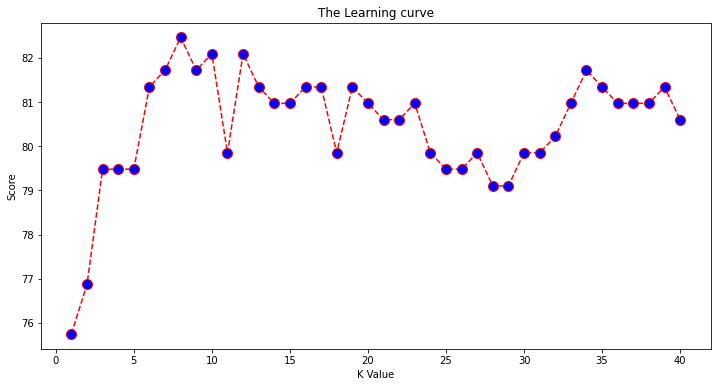

In [32]:
#绘制学习曲线
from sklearn.metrics import accuracy_score
score = []
for K in range(40):
    K_value = K+1
    knn = KNeighborsClassifier(n_neighbors = K_value, weights='uniform', algorithm='auto')
    knn.fit(x_train, y_train) 
    y_pred = knn.predict(x_test)
    score.append(round(accuracy_score(y_test,y_pred)*100,2))
    
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 41), score, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('The Learning curve')  
plt.xlabel('K Value')  
plt.ylabel('Score') 

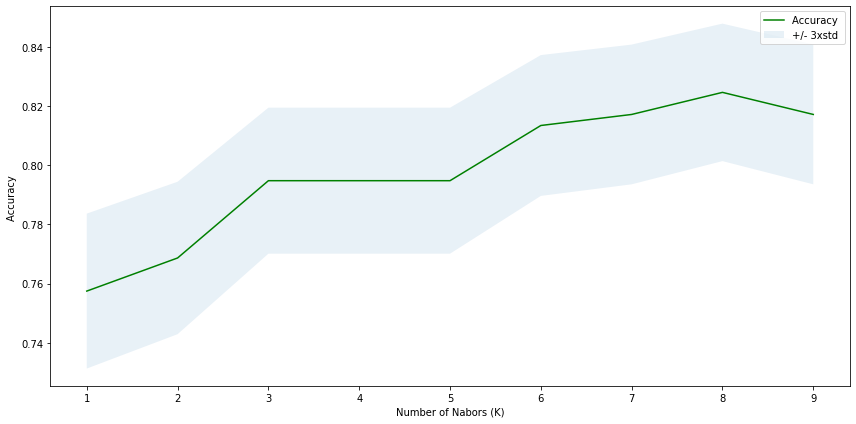

The best accuracy was with 0.8246268656716418 with k= 8


In [33]:
#带误差的学习曲线
from sklearn import metrics
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    # 模型训练和预测
    neigh = KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    yhat=neigh.predict(x_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

# 绘图
plt.figure(figsize=(12,6))
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", 
          mean_acc.max(), "with k=", 
          mean_acc.argmax()+1) 

Text(0, 0.5, 'Mean Error')

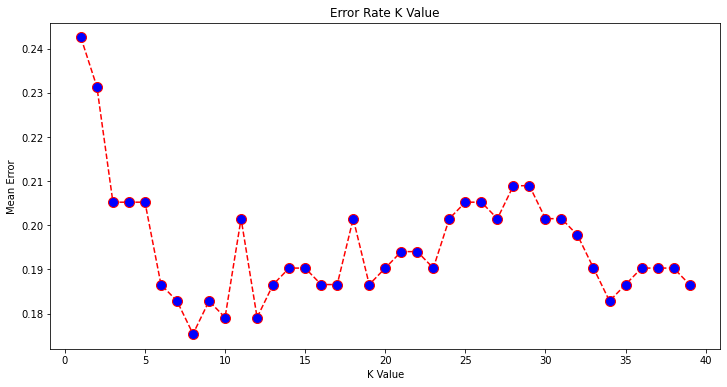

In [34]:
#误差率可视化
error = []

# 计算K值在1-40之间多误差值
for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error') 